In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv("./drive/My Drive/Datasets/UNSW-Specific/Service_Scan.csv",sep=';',float_precision='high')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
data.drop(['dir','srcid','smac','dmac','soui','doui','sco','dco','record'],axis=1,inplace=True)

In [0]:
#Fixing python curse of floating numbers
data['ltimeSTR'] = round(data['ltime'],0).astype(str)

In [0]:
#Finally I found on stackoverflow how to do this thing, spending for whole month (or several months)
test = data.iloc[:5000].groupby(['daddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())
test

0       1
1       1
2       1
3       1
4       1
       ..
4995    1
4996    3
4997    4
4998    1
4999    5
Name: bytes, Length: 5000, dtype: int64

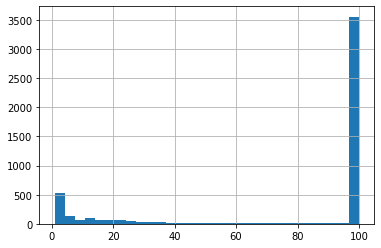

In [0]:
testp = pd.concat([test,data['attack'].iloc[:5000]],axis=1)
testp[testp['attack'] == 1]['bytes'].hist(bins=30)

In [0]:
#generating additional features
data['N_IN_Conn_P_SrcIP'] = data.groupby(['saddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())
data['N_IN_Conn_P_DstIP'] = data.groupby(['daddr','ltimeSTR'])['bytes'].transform(lambda x:x.rolling(100,1).count())


In [0]:
data.head()

,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,state,ltime,seq,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory,ltimeSTR,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP
0,1.526344e+09,e,arp,192.168.100.1,NaN,192.168.100.3,NaN,4,240,CON,1.526345e+09,9,1195.996582,0.000006,0.000002,0.000011,0.000004,0.000007,2,2,120,120,0.002508,0.000836,0.000836,0,Normal,Normal,1526345317.0,1,1
1,1.526344e+09,e,tcp,192.168.100.7,139,192.168.100.4,36390,10,680,CON,1.526346e+09,10,1453.945923,0.000028,0.000008,0.000138,0.000022,0.000042,5,5,350,330,0.006190,0.002751,0.002751,0,Normal,Normal,1526345677.0,1,1
2,1.526344e+09,e,udp,192.168.100.149,51838,27.124.125.250,123,2,180,CON,1.526344e+09,11,0.048565,0.048565,0.000000,0.048565,0.048565,0.048565,1,1,90,90,20.590960,0.000000,0.000000,0,Normal,Normal,1526344227.0,1,1
3,1.526344e+09,e,arp,192.168.100.4,NaN,192.168.100.7,NaN,10,510,CON,1.526346e+09,12,1454.080322,0.000238,0.000022,0.001189,0.000199,0.000261,5,5,210,300,0.006189,0.002751,0.002751,0,Normal,Normal,1526345682.0,1,1
4,1.526344e+09,e,udp,192.168.100.27,58999,192.168.100.1,53,4,630,CON,1.526345e+09,14,569.933960,0.098505,0.080150,0.197011,0.018356,0.178655,2,2,174,456,0.005264,0.001755,0.001755,0,Normal,Normal,1526344873.0,1,1


In [0]:
data.drop(['stime','flgs','ltime','pkts','bytes','dur','sum','spkts','dpkts','sbytes','dbytes','rate','category','subcategory','ltimeSTR'],axis=1,inplace=True)

In [0]:
#StateConverter
from collections import defaultdict
knownstatemap = {'RST':1,'CON':2,'REQ':3,'INT':4,'URP':5,'FIN':6,'ACC':7,'NRS':8,'ECO':9,'TST':10,'MAS':11}
statemap = defaultdict(lambda: "0", knownstatemap)
data['state']=data['state'].map(statemap)

In [0]:
plt.figure(figsize=(8,8))
graph1 = sns.scatterplot(x='N_IN_Conn_P_SrcIP', y='N_IN_Conn_P_DstIP',hue='attack',data=data)

KeyboardInterrupt: ignored

<Figure size 576x576 with 0 Axes>

In [0]:
data = data[['proto', 'saddr', 'sport', 'daddr', 'dport', 'state', 'seq', 'mean', 'stddev', 'min', 'max', 'srate', 'drate', 'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP','attack']]

In [0]:
data[data.iloc[:,5].isnull() == True]

,proto,saddr,sport,daddr,dport,state,seq,mean,stddev,min,max,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,attack


In [0]:
#split train/test Data
data['state'].fillna(0,inplace=True)
from sklearn.model_selection import train_test_split
traindata,testdata = train_test_split(data, train_size=0.7,random_state=7)

train_x,train_y = traindata.iloc[:,5:-1],traindata.iloc[:,-1]
test_x,test_y = testdata.iloc[:,5:-1],testdata.iloc[:,-1]

In [0]:
train_x

,state,seq,mean,stddev,min,max,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP
277629,1,120922,0.043418,0.000000,0.043418,0.043418,0.00000,0.000000,100,100
1179882,1,36106,0.003685,0.000000,0.003685,0.003685,0.00000,0.000000,100,100
581007,1,81690,0.001937,0.000000,0.001937,0.001937,0.00000,0.000000,100,100
616050,1,116734,0.020052,0.000000,0.020052,0.020052,0.00000,0.000000,100,100
1439816,6,294931,0.108059,0.093021,0.015038,0.201081,0.90185,0.601234,13,58
...,...,...,...,...,...,...,...,...,...,...
839891,1,20298,0.000545,0.000000,0.000545,0.000545,0.00000,0.000000,100,100
535030,1,35713,0.001282,0.000000,0.001282,0.001282,0.00000,0.000000,100,100
573977,1,74660,0.022233,0.000000,0.022233,0.022233,0.00000,0.000000,100,100
1238212,1,94436,0.009855,0.000000,0.009855,0.009855,0.00000,0.000000,100,100


In [0]:
train_y

277629     1
1179882    1
581007     1
616050     1
1439816    1
          ..
839891     1
535030     1
573977     1
1238212    1
585903     1
Name: attack, Length: 1026267, dtype: int64

In [0]:
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
scaler = preprocessing.MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [0]:
#train_x,train_y = SMOTE().fit_resample(train_x, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
pd.DataFrame(train_x)

In [0]:
#TRAIN!!
#from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=6, random_state=0,n_estimators=120)
model.fit(train_x, train_y)  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [0]:
np.where(np.isnan(train_x))

In [0]:
train_x[482970][0]

nan

In [0]:
%timeit result_y = model.predict([[4.44444444e-01,8.01907438e-03,1.30088278e-05,0.00000000e+00,1.30088278e-05,1.30000026e-05,1.53846152e-02,0.00000000e+00,7.47474747e-01,7.47474747e-01]])

100 loops, best of 3: 8.62 ms per loop


In [0]:
%timeit tedddddddddddd = model.predict(test_x)

In [0]:
result_yt = model.predict_proba(test_x)

In [0]:
result_yta = np.where(result_yt[:,1] >= 0.99,1,0)
result_yta

array([1, 1, 1, ..., 1, 1, 1])

In [0]:
from sklearn import metrics
ACR= metrics.accuracy_score(test_y,result_yta)
PRC= metrics.precision_score(test_y,result_yta)
RCL= metrics.recall_score(test_y,result_yta)
print('Accuracy = ' + str(ACR))
print('Precision = ' + str(PRC))
print('Recall = ' + str(RCL))
cm=metrics.confusion_matrix(test_y,result_yta)

Accuracy = 0.9671600391060182
Precision = 0.9999976446979796
Recall = 0.9671014268272683


In [0]:
cm

array([[   813,      1],
       [ 14443, 424573]])

In [0]:
tupleA = np.sum(test_y==0),np.sum(test_y==1)
print(*tupleA)

814 439016


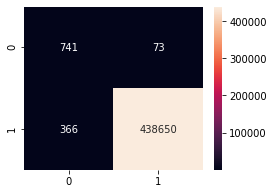

In [0]:
plt.figure(figsize=(4,3))
cmplot = sns.heatmap(cm, annot=True,fmt="d")

In [0]:
import joblib
joblib.dump(scaler, 'minmax005.jlb') 
joblib.dump(model, 'model005.jlb') 


['model005.jlb']